In [30]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import fetch_20newsgroups

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

import pickle


In [31]:
from sklearn.cluster import KMeans
from time import time
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics.cluster import contingency_matrix
from plotmat import plot_mat 
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

In [32]:
def return_metrics_score(clusterer,labels,train_embeddings):
    hom = homogeneity_score(labels, clusterer.labels_)
    completeness = completeness_score(labels, clusterer.labels_)
    v_measure = v_measure_score(labels, clusterer.labels_)
    rand_score = adjusted_rand_score(labels, clusterer.labels_)
    mu_info = adjusted_mutual_info_score(labels, clusterer.labels_)
    cm = confusion_matrix(labels, clusterer.labels_)
    return hom,completeness,v_measure,rand_score,mu_info,cm


In [33]:

def print_metrics(km,labels,train_embeddings):
    print("Homogeneity: %0.3f" % homogeneity_score(labels, km.labels_))
    print("Completeness: %0.3f" % completeness_score(labels, km.labels_))
    print("V-measure: %0.3f" % v_measure_score(labels, km.labels_))
    print("Adjusted Rand-Index: %.3f" % adjusted_rand_score(labels, km.labels_))
    print("Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(labels, km.labels_))
    print("Contingency matrix:")

    cm = confusion_matrix(labels, km.labels_)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

In [34]:
def get_best_performance(metrics_dict,metric_key):
    "returns the best hyperparameters,and index of the best metric for the max values of the passed metric for a given search of models"
    values =  metrics_dict[metric_key]
    index_max = max(range(len(values)), key=values.__getitem__)
    best_hyper = metrics_dict['hyperparameters'][index_max]
    return index_max,best_hyper

In [35]:
def print_confusion_matrix(cm,labels,km):
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

# Q10 Load documents with the same configuration as in Question 1, but for ALL 20 categories. Construct the TF-IDF matrix, reduce its dimensionality properly using either NMF or SVD, and perform K-Means clustering with k=20 . Visualize the contingency matrix and report the five clustering metrics.


## Full Dataset (Q10)

In [36]:
train_full = fetch_20newsgroups(subset='train',  shuffle=True, random_state=42, remove=('headers', 'footers'))
test_full = fetch_20newsgroups(subset='test',  shuffle=True, random_state=42, remove=('headers', 'footers'))

In [37]:
train_full_data = train_full.data
y_train_full = list(train_full.target)
test_full_data =  test_full.data
y_test_full_data = list(test_full.target)

## Count Vectorizing and TFIDF

In [38]:
count_vect = CountVectorizer(stop_words='english', min_df=3, max_df=0.7)
X_train_full_count = count_vect.fit_transform(train_full_data)
tfidf_transformer = TfidfTransformer()
X_train_full_tfidf = tfidf_transformer.fit_transform(X_train_full_count)


# K-Means on Full Dataset SVD and NMF

## SVD Dimension Reduction for the 20 classes

In [10]:

svd_ncomponents = [5,20,200]

metrics_dict_svd = {'homogenity': [],'completeness':[] ,'v_measure':[] ,'adjusted_rand':[],'mutual_info':[],'confusion_matrices':[],'hyperparameters':[]}

svd_embeddings = []
kms_svd = []
true_k = 20
for n_com in svd_ncomponents:
    svd = TruncatedSVD(n_components=n_com, n_iter = 20, random_state=42)
    train_full_svd = svd.fit_transform(X_train_full_tfidf)
    svd_embeddings.append(train_full_svd)
    km = KMeans(
        n_clusters=true_k,
        init="k-means++",
        max_iter=2000,
        n_init=100)
    km.fit(train_full_svd)
    kms_svd.append(km)
    hom,completeness,v_measure,rand_score,sil_coeff,cm = return_metrics_score(km,labels = y_train_full,train_embeddings=train_full_svd)

    metrics_dict_svd['homogenity'].append(hom)
    metrics_dict_svd['completeness'].append(completeness)
    metrics_dict_svd['v_measure'].append(v_measure)
    metrics_dict_svd['adjusted_rand'].append(rand_score)
    metrics_dict_svd['mutual_info'].append(sil_coeff)
    metrics_dict_svd['confusion_matrices'].append(cm)
    metrics_dict_svd['hyperparameters'].append([n_com])

In [46]:
with open('metrics_dict_svd.pkl', 'wb') as f:
    pickle.dump(metrics_dict_svd, f)

with open('kms_svd.pkl', 'wb') as f:
    pickle.dump(kms_svd, f)

## NMF Dimension Reduction for 20 classes

In [21]:


nmf_ncomponents = [5,20,200]

metrics_dict_nmf = {'homogenity': [],'completeness':[] ,'v_measure':[] ,'adjusted_rand':[],'mutual_info':[],'confusion_matrices':[],'hyperparameters':[]}

nmf_embeddings = []
kms_nmf = []
true_k = 20
for n_com in nmf_ncomponents:
    nmf = NMF(n_components=n_com,  random_state=42)
    train_full_nmf = nmf.fit_transform(X_train_full_tfidf)
    nmf_embeddings.append(train_full_nmf)
    km = KMeans(
        n_clusters=true_k,
        init="k-means++",
        max_iter=2000,
        n_init=100)
    km.fit(train_full_nmf)
    kms_nmf.append(km)
    hom,completeness,v_measure,rand_score,sil_coeff,cm = return_metrics_score(km,labels = y_train_full,train_embeddings=train_full_nmf)

    metrics_dict_nmf['homogenity'].append(hom)
    metrics_dict_nmf['completeness'].append(completeness)
    metrics_dict_nmf['v_measure'].append(v_measure)
    metrics_dict_nmf['adjusted_rand'].append(rand_score)
    metrics_dict_nmf['mutual_info'].append(sil_coeff)
    metrics_dict_nmf['confusion_matrices'].append(cm)
    metrics_dict_nmf['hyperparameters'].append([n_com])

/home/anw/ucla_coursework/219/code/ECE219_data_mining_project/env219/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/home/anw/ucla_coursework/219/code/ECE219_data_mining_project/env219/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/home/anw/ucla_coursework/219/code/ECE219_data_mining_project/env219/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [47]:
with open('metrics_dict_nmf.pkl', 'wb') as f:
    pickle.dump(metrics_dict_nmf, f)

with open('kms_nmf.pkl', 'wb') as f:
    pickle.dump(kms_nmf, f)

In [12]:
def compare_plot_metrics_svd_nmf(metrics_dict,plot_for = 'svd'):
    for key, value in metrics_dict.items():
        
        if key != 'confusion_matrices' and key != 'hyperparameters':
            fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
            if plot_for =='svd':
                fig.suptitle('{} per n components SVD '.format(key))
                ax1.plot(svd_ncomponents, value)
            elif plot_for =='nmf':
                fig.suptitle('{} per n components NMF '.format(key))
                ax1.plot(nmf_ncomponents, value)
            ax1.set_xlabel("Number of Components")
            ax1.set_ylabel(key)
            plt.show()

## Loading Pickled data

In [ ]:
        
with open('metrics_dict_svd.pkl', 'rb') as f:
    metrics_dict_svd = pickle.load(f)

with open('metrics_dict_nmf.pkl', 'rb') as f:
    metrics_dict_nmf = pickle.load(f)

with open('kms_svd.pkl', 'rb') as f:
    kms_svd = pickle.load(f)

with open('kms_nmf.pkl', 'rb') as f:
    kms_nmf = pickle.load(f)

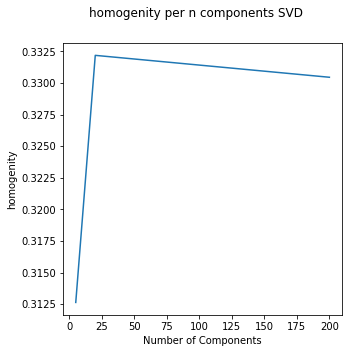

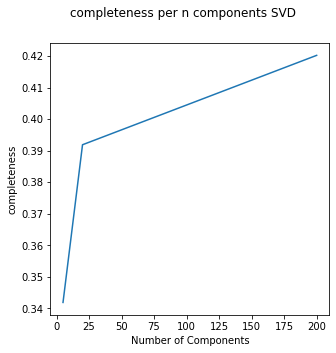

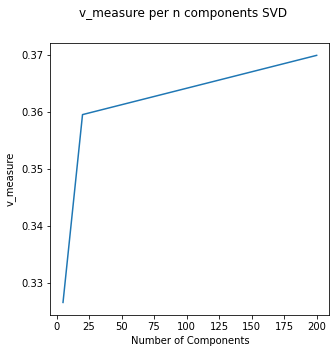

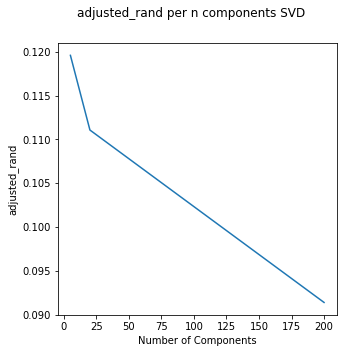

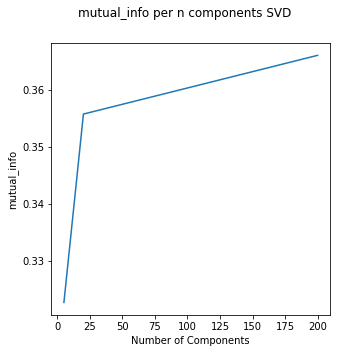

In [13]:
compare_plot_metrics_svd_nmf(metrics_dict_svd,'svd')

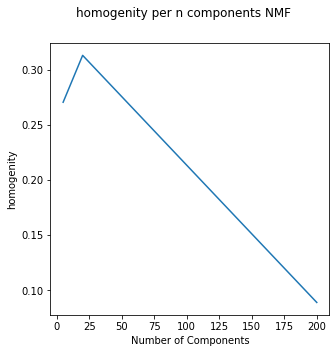

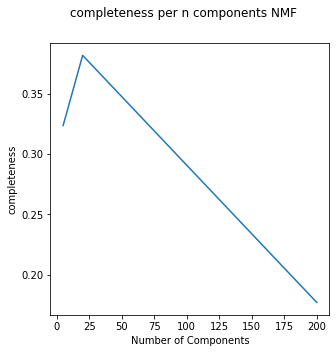

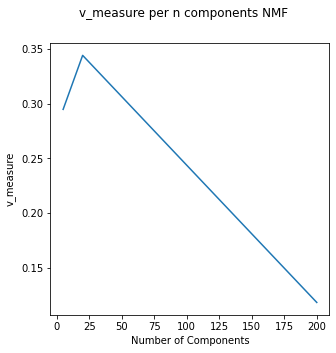

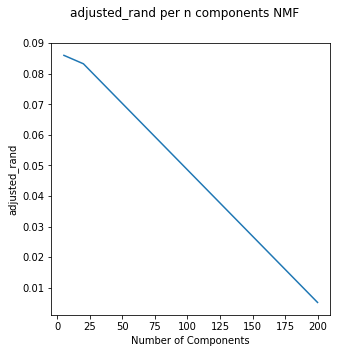

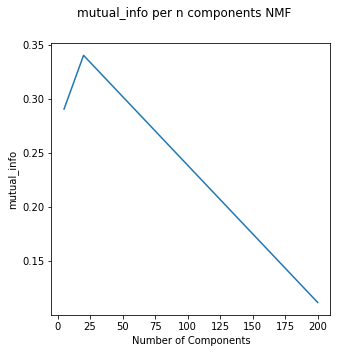

In [22]:
compare_plot_metrics_svd_nmf(metrics_dict_nmf,'nmf')

In [15]:
best_index_hom_svd, hypers_svd = get_best_performance(metrics_dict_svd,'homogenity')


In [24]:
best_index_hom_nmf, hypers_nmf = get_best_performance(metrics_dict_nmf,'homogenity')

## Best SVD Performance

Homogeneity: 0.332
Completeness: 0.392
V-measure: 0.360
Adjusted Rand-Index: 0.111
Adjusted Mutual Information Score: 0.356
Contingency matrix:


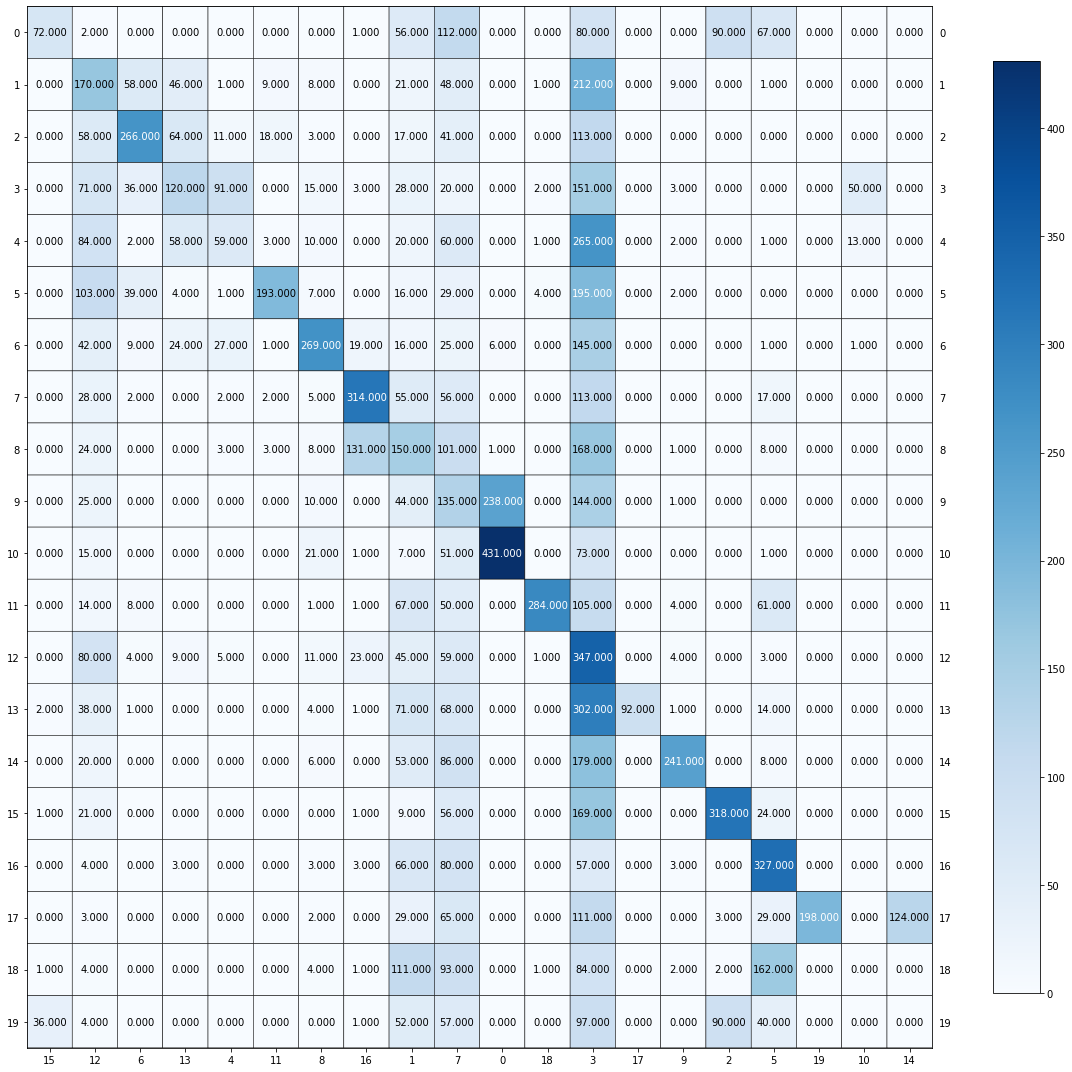

Best Number of components for SVD full dataset 20 


In [19]:
print_metrics(kms_svd[best_index_hom_svd],labels=y_train_full,train_embeddings=train_full_svd)
print("Best Number of components for SVD full dataset {} ".format(*hypers_svd))

## Best NMF Performance

Homogeneity: 0.313
Completeness: 0.382
V-measure: 0.344
Adjusted Rand-Index: 0.083
Adjusted Mutual Information Score: 0.340
Contingency matrix:


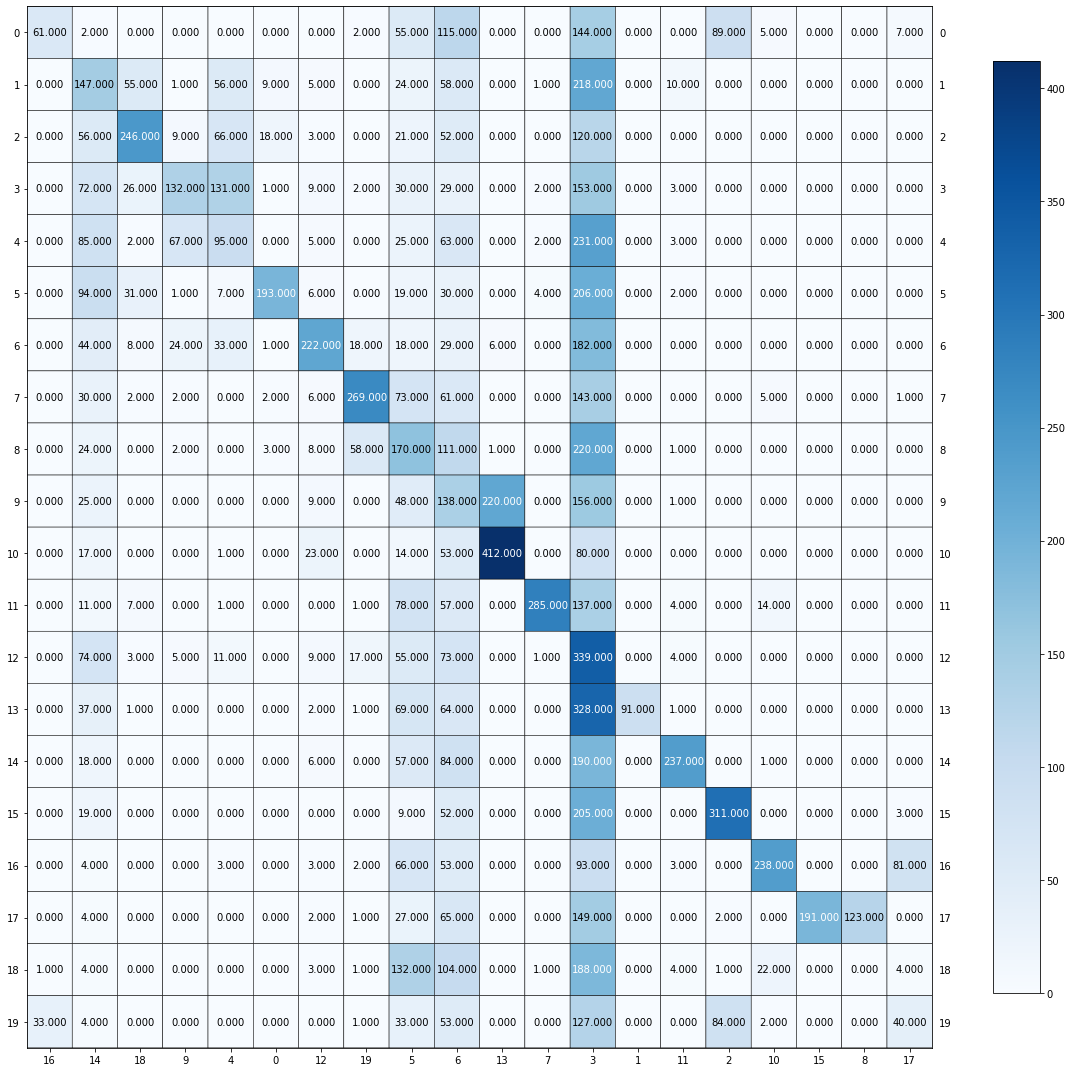

Best Number of components for NMF full dataset  20 


In [26]:
print_metrics(kms_nmf[best_index_hom_nmf],labels=y_train_full,train_embeddings=train_full_nmf)
print("Best Number of components for NMF full dataset  {} ".format(*hypers_nmf))

## UMAP Dimension Reduction

In [40]:
import umap

import umap.plot

In [41]:
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE
output_notebook(resources=INLINE)

Loading BokehJS ...

# Q11 Use UMAP to reduce the dimensionality of the 20 category TF-IDF matrix and apply K-Means clustering with n_components=20
## Find a good n components choice for UMAP, and compare the performance of two metrics by setting metric="euclidean" and metric="cosine" respectively. Report the permuted contingency matrix and the five clustering evaluation metrics for "euclidean" and "cosine".

In [42]:

svd_r = [50,20,200]
nmf = [50,20,200]
umap_N_components = [5,20,200]
k_means_k = [10,20,50]
agg_clustering_n_clusters = [20]
agg_linkage = ['ward','single']
dbscan_min_cluster_size = [100,200]
hdbscan_min_cluster_size = [100,200]
umap_metrics = ['euclidean','cosine']

## Optimizing UMAP Hyperparameters

In [32]:
metrics_dict_umap = {'homogenity': [],'completeness':[] ,'v_measure':[] ,'adjusted_rand':[],'mutual_info':[],'confusion_matrices':[],'hyperparameters':[]}
umap_N_components = [5,20,200]
umap_metrics = ['euclidean','cosine']
umap_embeddings = []
kms_umap = []
true_k = 20
for n_com in umap_N_components:
    for metric in umap_metrics:
        embedding=umap.UMAP(n_components=n_com, metric=metric).fit(X_train_full_tfidf)
        umap_embeddings.append(embedding)
        km = KMeans(
            n_clusters=true_k,
            init="k-means++",
            max_iter=2000,
            n_init=100)
        km.fit(embedding.embedding_)
        kms_umap.append(km)
        hom,completeness,v_measure,rand_score,sil_coeff,cm = return_metrics_score(km,labels = y_train_full,train_embeddings=embedding.embedding_)
    
        metrics_dict_umap['homogenity'].append(hom)
        metrics_dict_umap['completeness'].append(completeness)
        metrics_dict_umap['v_measure'].append(v_measure)
        metrics_dict_umap['adjusted_rand'].append(rand_score)
        metrics_dict_umap['mutual_info'].append(sil_coeff)
        metrics_dict_umap['confusion_matrices'].append(cm)
        metrics_dict_umap['hyperparameters'].append([n_com,metric])
    

In [37]:
def compare_plot_metrics(metrics_dict):
    for key, value in metrics_dict.items():
        
        if key != 'confusion_matrices' and key != 'hyperparameters':
            fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7, 14))
            fig.suptitle('Euclidean Vs Cosine: {} '.format(key))
            ax1.plot(umap_N_components, value[0::2])
            ax1.set_title("Euclidean")
            # ax1.title(metrics_dict['hyperparameters'][1])
            ax2.set_title("Cosine")
            ax2.plot(umap_N_components, value[1::2])
            # ax2.title(metrics_dict['hyperparameters'][1])
            ax1.set_xlabel("Number of Components")
            ax2.set_xlabel("Number of Components")
            ax1.set_ylabel(key)
            ax2.set_ylabel(key)
            plt.show()

In [72]:
with open('metrics_dict_umap.pkl', 'wb') as f:
    pickle.dump(metrics_dict_umap, f)

with open('kms_umap.pkl', 'wb') as f:
    pickle.dump(kms_umap, f)

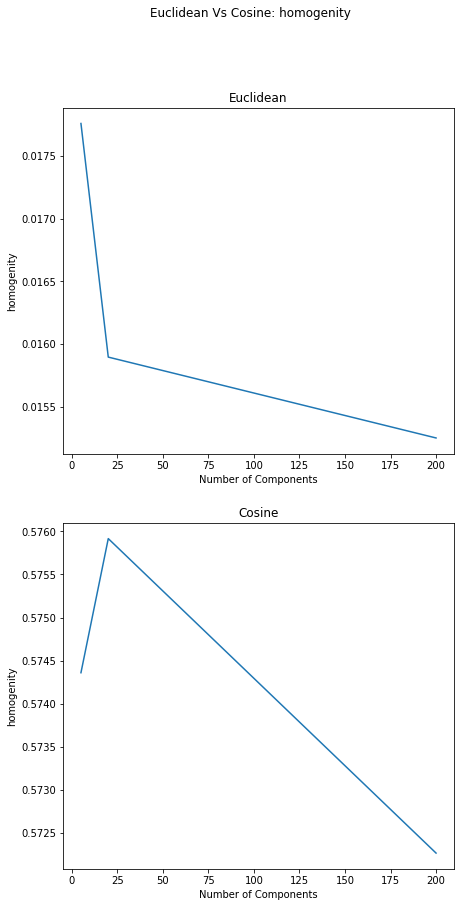

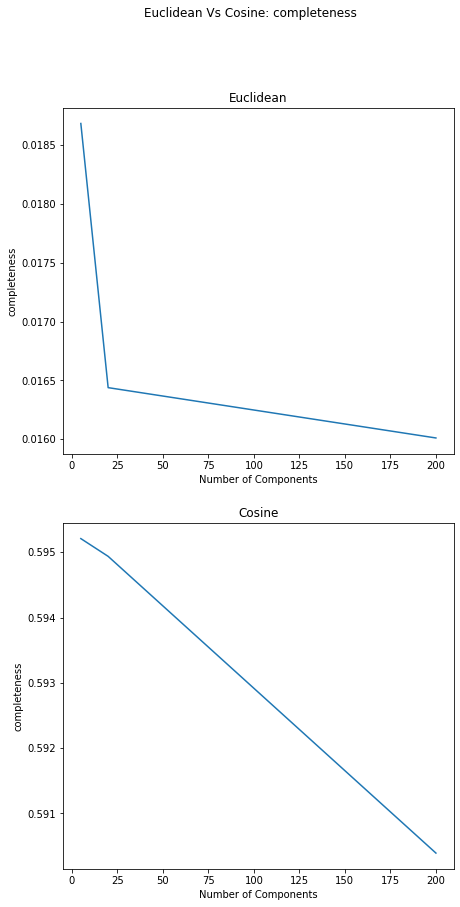

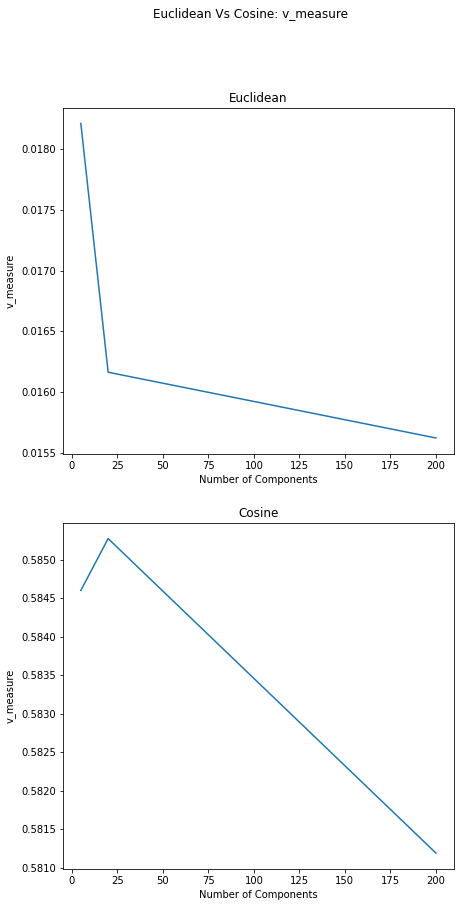

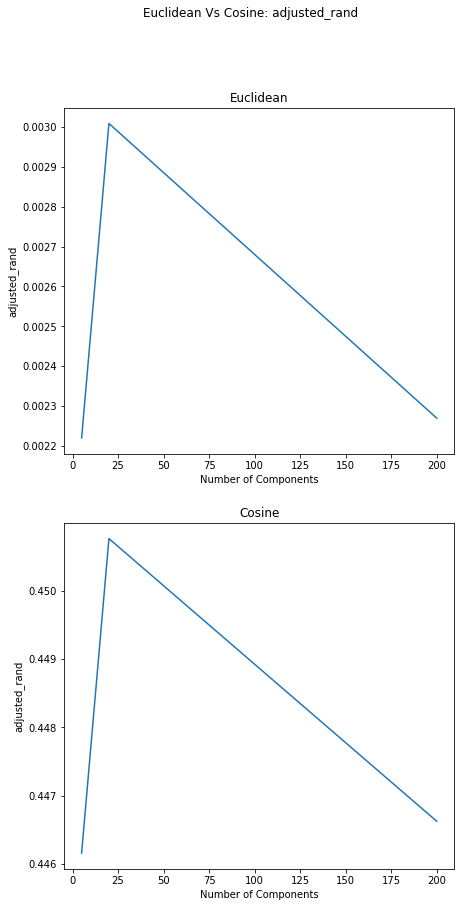

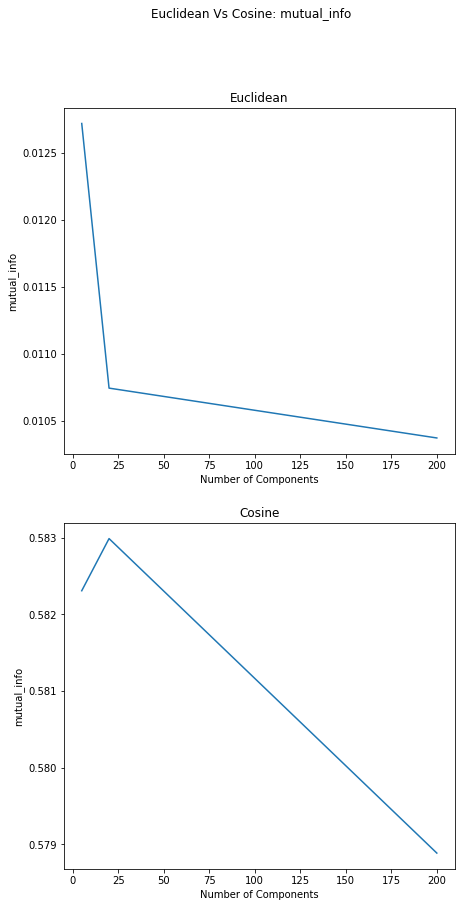

In [38]:
compare_plot_metrics(metrics_dict_umap)

In [40]:
best_index_hom_umap, hypers_umap = get_best_performance(metrics_dict_umap,'homogenity')
print("Best Hyperparameters for UMAP n_com {} Distance Metric {} ".format(*hypers_umap))

Best Hyperparameters for UMAP n_com 20 Distance Metric cosine 


Best UMAP Performance


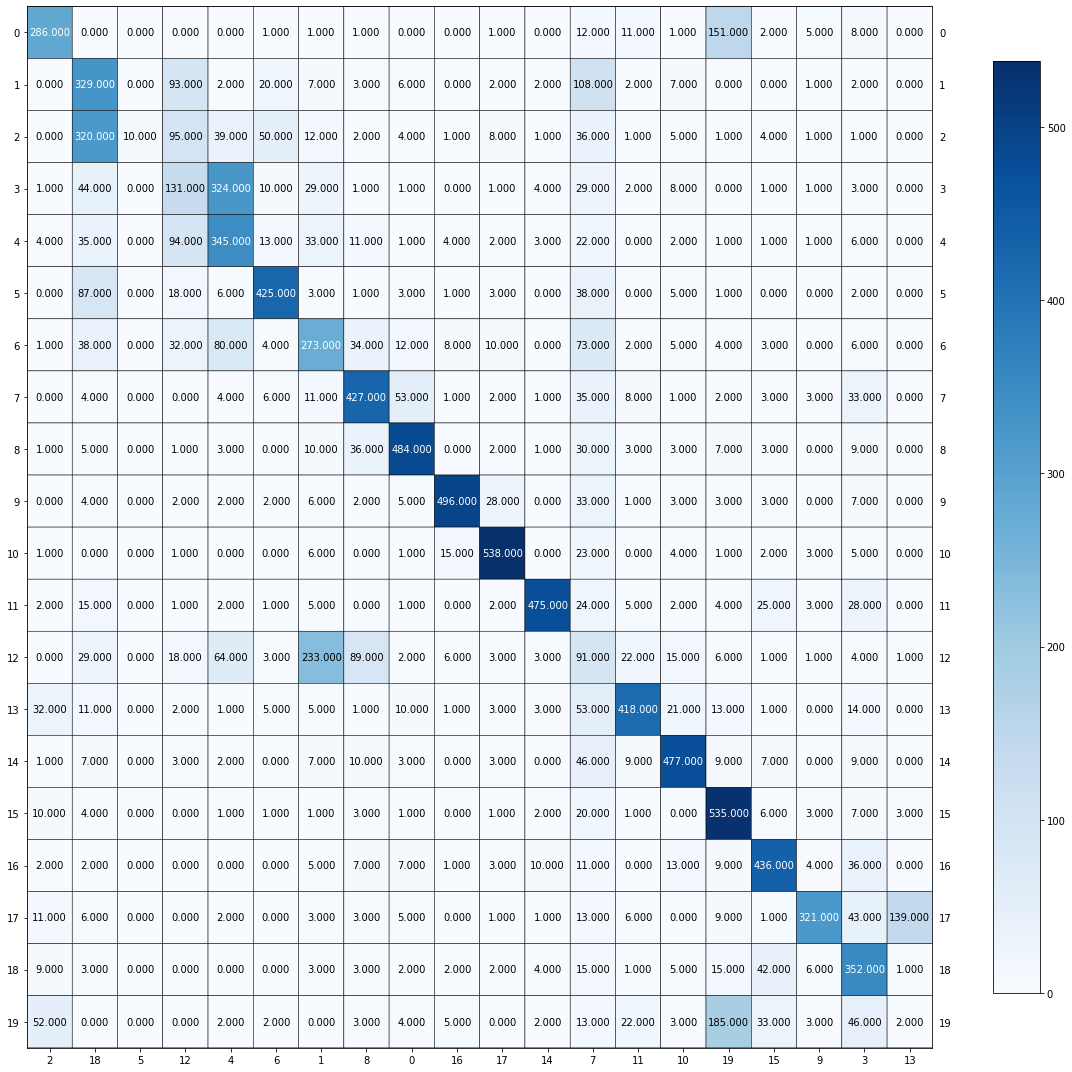

In [41]:
print("Best UMAP Performance")
print_confusion_matrix(cm=metrics_dict_umap['confusion_matrices'][best_index_hom_umap],labels=y_train_full,km=kms_umap[best_index_hom_umap])

Euclidean Performance


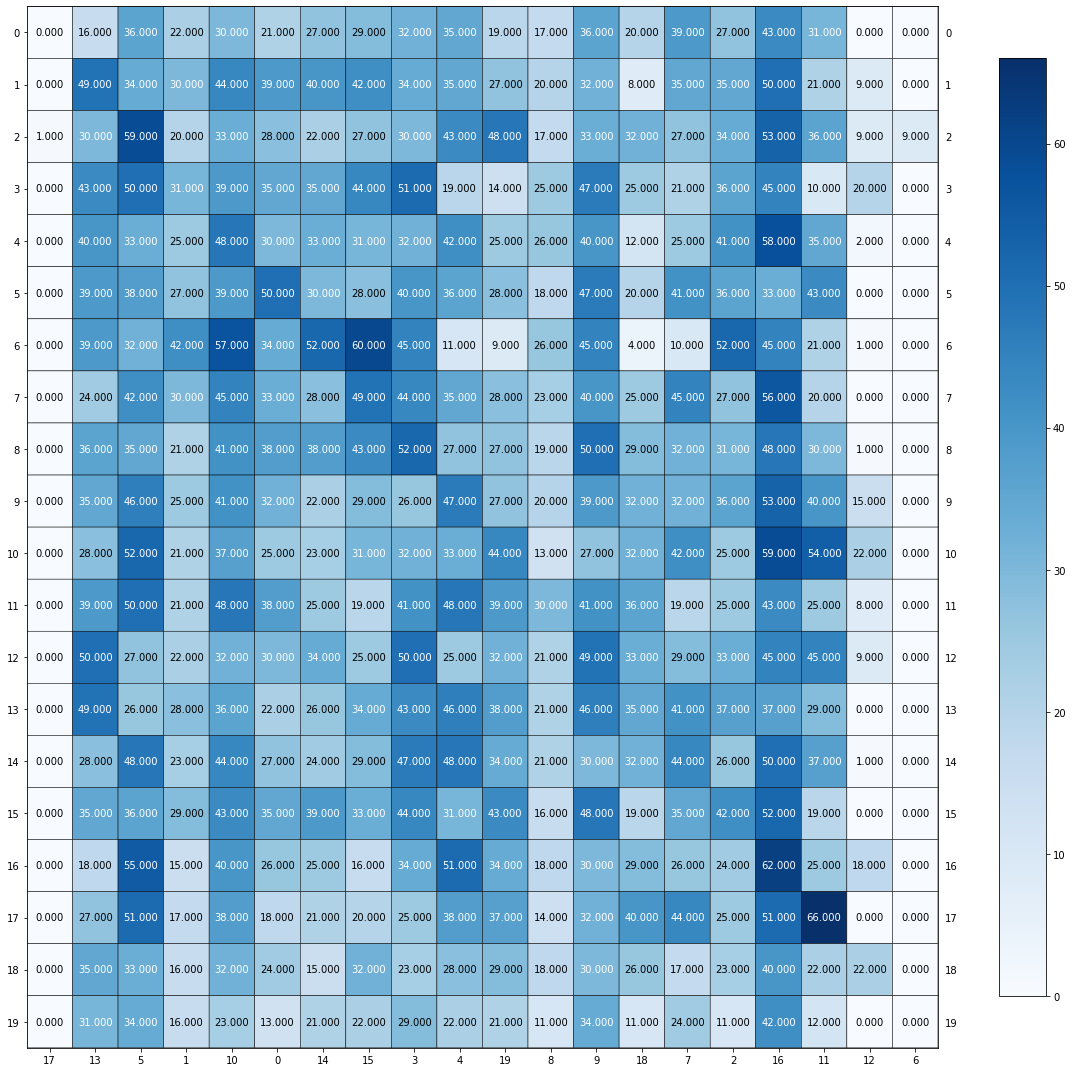

In [42]:
print("Euclidean Performance")
print_confusion_matrix(cm=metrics_dict_umap['confusion_matrices'][4],labels=y_train_full,km=kms_umap[4])

## Some observations
- Cosine distance metric performs much better than Euclidean distance metric
- Given this is a high dimensional space, the cosine distance works better since it does not take into account the magnitude of the tfidf vectors, only the similarity between them. Comparing magnitudes in this case is not that relevant, since document sizes are uneven.
- UMAP number of components =200 has the best clustering metrics overall

## Contingency Matrix
- The clusters names don't match the actual clusters, but we can see a clear match between the actual classes and the clustering performance of the kmeans
- The homogeniety is relatively good for cosine and n_com=200. For Euclidean distance metric, the contningency matrix does not show a good association between clusters

# QUESTION 13 So far, we have attempted K-Means clustering with 4 different representation learning techniques (sparse representation, PCA, NMF, UMAP). Compare and contrast the results from the previous sections, and discuss which approach is best for the K-Means clustering task on the 20-class text data

# Comparing Different Dimensionality techniques - The best Results for the 20 class data
## UMAP N_components = 20    Distance Metric = cosine
## NMF  r = 20   for 20 class data
## SVD  r = 3

In [ ]:
print_metrics(kms_svd[best_index_hom_svd],labels=y_train_full,train_embeddings=train_full_svd)

In [ ]:
# print_metrics(km_nmf,labels=y_train_full,train_embeddings=train_full_nmf)
print_metrics(kms_nmf[best_index_hom_nmf],labels=y_train_full,train_embeddings=train_full_nmf)


In [ ]:
# Best UMAP
print_metrics(kms_umap[best_index_hom_umap],labels=y_train_full,train_embeddings=umap_embeddings[best_index_hom_umap].embedding_)


## Some key points:
- UMAP is much faster than SVD or NMF, for the same of components.
    -  Searching through 3 components for SVD took 17m 27.4 s
    -  Searching through 3 components for NMF took 22m 24 s
    -  Searching through 3 components for UMAP took 6m 13.8 s
- 200 component data on UMAP runs faster than 20 component on SVD or NMF
- The clustering metrics for UMAP dimensionality reduction is better than SVD and NMF
- The contingency matrix for UMAP shows a better association between actual classes and clusters


# QUESTION 14 Use UMAP to reduce the dimensionality properly, and perform Agglomerative clustering with n_clusters=20 . Compare the performance of “ward” and “single” linkage criteria.

In [39]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
# import hdbscan

## Agglomerative Clustering 

## Optimize Agglomerative Clustering Hyperparameters

In [60]:
metrics_dict_agg = {'homogenity': [],'completeness':[] ,'v_measure':[] ,'adjusted_rand':[],'mutual_info':[],'confusion_matrices':[],'hyperparameters':[]}

umap_embeddings = []
n_clusters = 20
n_com =20
umap_metric ='cosine'
embedding=umap.UMAP(n_components=n_com, metric=umap_metric).fit(X_train_full_tfidf)
aggs = []
# for n_com in umap_N_components:
for metric in agg_linkage:
    
    # umap_embeddings.append(embedding)
    agg = AgglomerativeClustering(n_clusters =n_clusters, linkage=metric)
    agg.fit(embedding.embedding_)
    aggs.append(agg)
    hom,completeness,v_measure,rand_score,sil_coeff,cm = return_metrics_score(agg,labels = y_train_full,train_embeddings=embedding.embedding_)
    metrics_dict_agg['homogenity'].append(hom)
    metrics_dict_agg['completeness'].append(completeness)
    metrics_dict_agg['v_measure'].append(v_measure)
    metrics_dict_agg['adjusted_rand'].append(rand_score)
    metrics_dict_agg['mutual_info'].append(sil_coeff)
    metrics_dict_agg['confusion_matrices'].append(cm)
    metrics_dict_agg['hyperparameters'].append(metric)

In [54]:
def compare_plot_metrics_agg(metrics_dict):
    for key, value in metrics_dict.items():
        
        if key != 'confusion_matrices':
            fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7, 14))
            fig.suptitle('Ward Vs Linkage: {}'.format(key))
            ax1.plot(umap_N_components, value[0::2])
            ax2.plot(umap_N_components, value[1::2])
            ax1.set_xlabel("Number of Components")
            ax2.set_xlabel("Number of Components")
            ax1.set_ylabel(key)
            ax2.set_ylabel(key)
            plt.show()

In [71]:
with open('metrics_dict_agg.pkl', 'wb') as f:
    pickle.dump(metrics_dict_agg, f)

with open('aggs.pkl', 'wb') as f:
    pickle.dump(aggs, f)

In [61]:
best_index_hom_agg, hypers_agg = get_best_performance(metrics_dict_agg,'homogenity')
print("Best Linkage for Agg {}".format(hypers_agg))

Best Linkage for Agg ward


Homogeneity: 0.571
Completeness: 0.589
V-measure: 0.580
Adjusted Rand-Index: 0.448
Adjusted Mutual Information Score: 0.578
Contingency matrix:


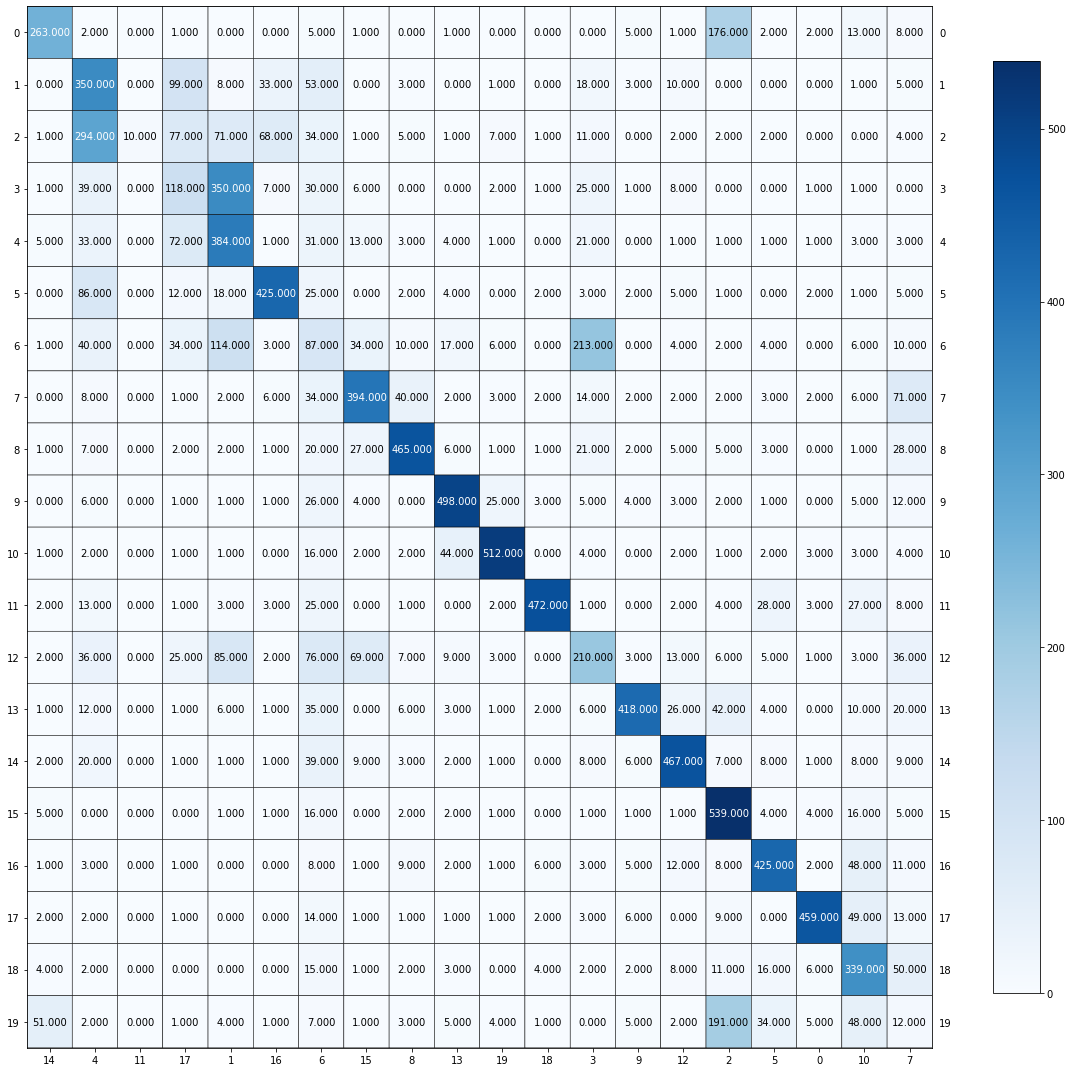

In [62]:
print_metrics(aggs[best_index_hom_agg],labels=y_train_full,train_embeddings=embedding.embedding_)

# QUESTION 15: Apply DBSCAN and HDBSCAN on UMAP-transformed 20-category data. Use min_cluster_size=100
## Experiment on the hyperparameters and report your findings in terms of the five clustering evaluation metrics

In [63]:
metrics_dict_dbs = {'homogenity': [],'completeness':[] ,'v_measure':[] ,'adjusted_rand':[],'mutual_info':[],'confusion_matrices':[],'hyperparameters':[]}

umap_embeddings = []
n_clusters = 20
n_com =20
umap_metric ='cosine'
embedding = umap.UMAP(n_components=n_com, metric=umap_metric).fit(X_train_full_tfidf)

min_samples = [5,15,30,60,100,200,500,1000,3000]
DBSCAN_eps = [0.5, 0.6, 0.8, 1.0, 3.0, 5.0, 10]
dbss = []

for eps in DBSCAN_eps:
    for min_sam in min_samples:
        dbs = DBSCAN(eps=eps,min_samples=min_sam,n_jobs=-1).fit(embedding.embedding_)
        dbs.fit(embedding.embedding_)
        dbss.append(dbs)
        hom,completeness,v_measure,rand_score,sil_coeff,cm = return_metrics_score(dbs,labels = y_train_full,train_embeddings=embedding.embedding_)
        metrics_dict_dbs['homogenity'].append(hom)
        metrics_dict_dbs['completeness'].append(completeness)
        metrics_dict_dbs['v_measure'].append(v_measure)
        metrics_dict_dbs['adjusted_rand'].append(rand_score)
        metrics_dict_dbs['mutual_info'].append(sil_coeff)
        metrics_dict_dbs['confusion_matrices'].append(cm)
        metrics_dict_dbs['hyperparameters'].append([eps,min_sam])

In [64]:
with open('metrics_dict_dbs.pkl', 'wb') as f:
    pickle.dump(metrics_dict_dbs, f)

with open('dbss.pkl', 'wb') as f:
    pickle.dump(dbss, f)


In [65]:
def compare_plot_metrics_dbs(metrics_dict):
    for key, value in metrics_dict.items():
        
        if key != 'confusion_matrices':
            fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
            fig.suptitle('epsilon for {}'.format(key))
            ax1.plot(DBSCAN_eps, value[0::9])
            # ax2.plot(umap_N_components, value[1::2])
            ax1.set_xlabel("Epsilon")
            # ax2.set_xlabel("Number of Components")
            ax1.set_ylabel(key)
            # ax2.set_ylabel(key)
            plt.show()

In [73]:
best_index_hom_dbs, hypers_dbs = get_best_performance(metrics_dict_dbs,'homogenity')
print("Best Hyperparamters for DBSCAN {}".format(hypers_dbs))

Best Hyperparamters for DBSCAN [0.5, 100]


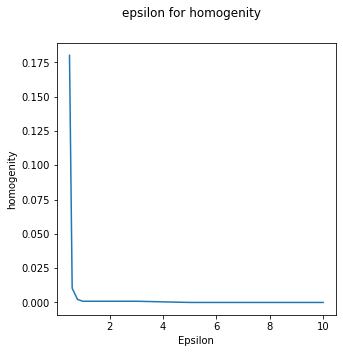

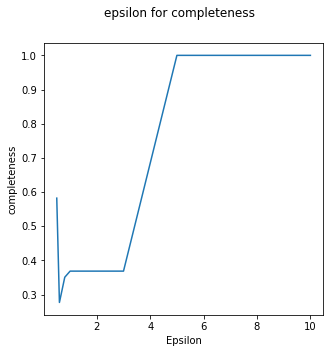

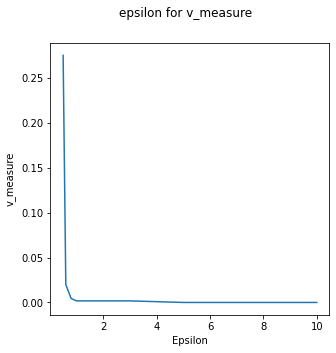

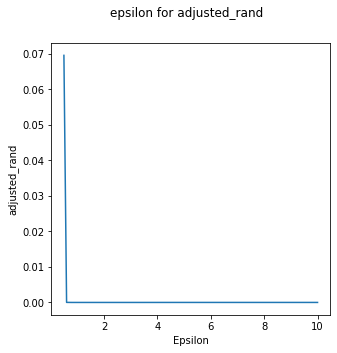

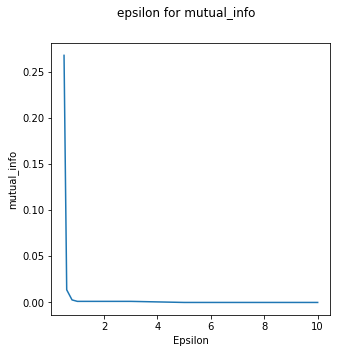

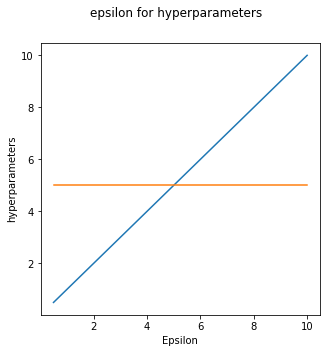

In [74]:
compare_plot_metrics_dbs(metrics_dict_dbs)

# QUESTION 16: Contingency matrix 
## Plot the contingency matrix for the best clustering model from Question 15. How many clusters are given by the model? What does “-1” mean for the clustering labels? Interpret the contingency matrix considering the answer to these questions.

# DBSCAN

Homogeneity: 0.496
Completeness: 0.569
V-measure: 0.530
Adjusted Rand-Index: 0.193
Adjusted Mutual Information Score: 0.527
Contingency matrix:


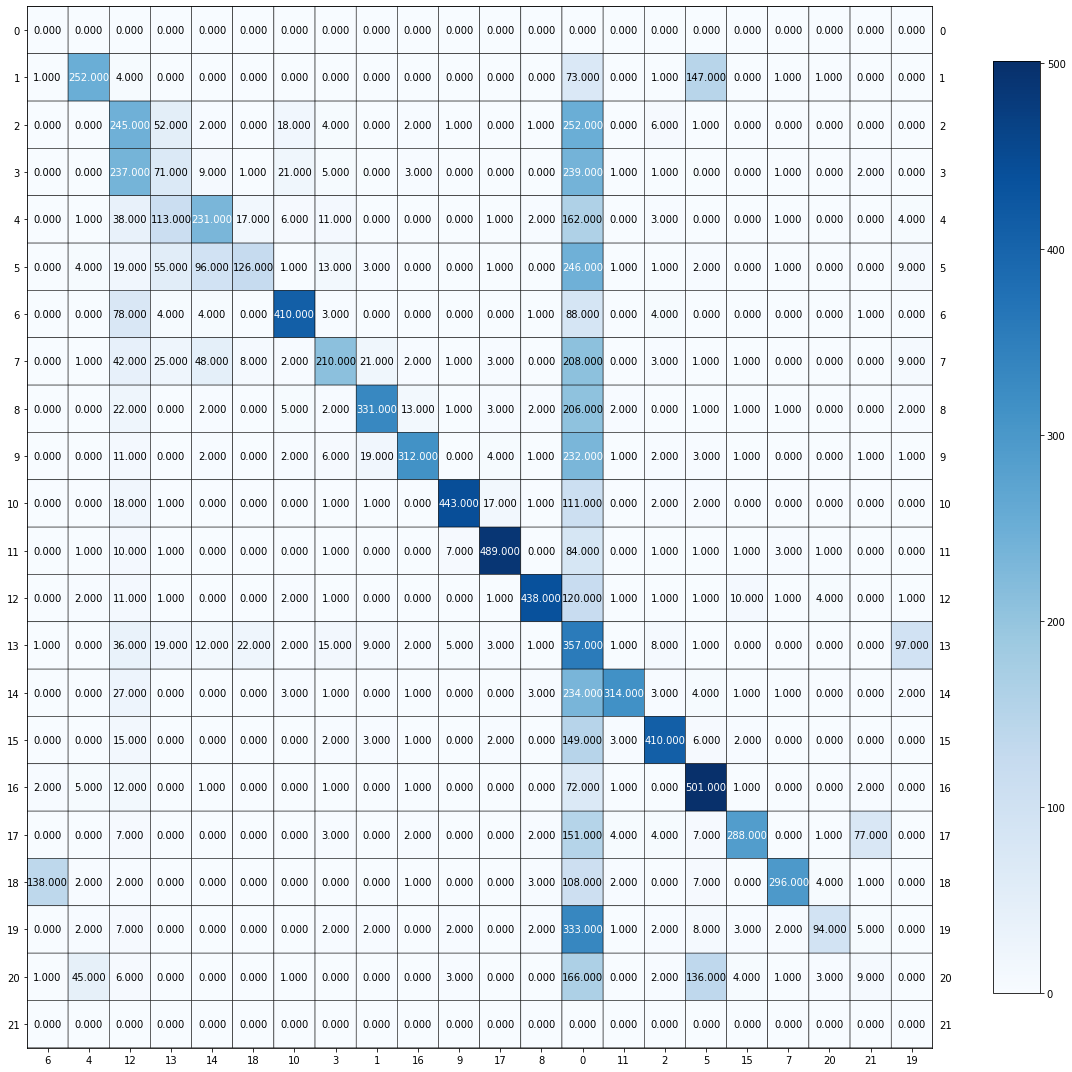

In [75]:
print_metrics(dbss[best_index_hom_dbs],labels=y_train_full,train_embeddings=embedding.embedding_)

In [76]:
import hdbscan

In [108]:
metrics_dict_hdbs = {'homogenity': [],'completeness':[] ,'v_measure':[] ,'adjusted_rand':[],'mutual_info':[],'confusion_matrices':[],'hyperparameters':[]}

umap_embeddings = []
n_clusters = 20
n_com =20
umap_metric ='cosine'
embedding = umap.UMAP(n_components=n_com, metric=umap_metric).fit(X_train_full_tfidf)

HDBSCAN_eps = [ 0.3 ,0.5, 0.6, 0.8, 1.0, 3.0, 5.0, 10]
min_samples = [5,15,30,60,100,200,500,1000,3000]


hdbss = []

for eps in HDBSCAN_eps:
    for min_sam in min_samples:
        hdbs = hdbscan.HDBSCAN(min_samples= min_sam, cluster_selection_epsilon= eps, min_cluster_size=100)
        hdbs.fit(embedding.embedding_)
        hdbss.append(hdbs)
        hom,completeness,v_measure,rand_score,sil_coeff,cm = return_metrics_score(hdbs,labels = y_train_full,train_embeddings=embedding.embedding_)
        metrics_dict_hdbs['homogenity'].append(hom)
        metrics_dict_hdbs['completeness'].append(completeness)
        metrics_dict_hdbs['v_measure'].append(v_measure)
        metrics_dict_hdbs['adjusted_rand'].append(rand_score)
        metrics_dict_hdbs['mutual_info'].append(sil_coeff)
        metrics_dict_hdbs['confusion_matrices'].append(cm)
        metrics_dict_hdbs['hyperparameters'].append([eps,min_sam])

In [109]:
with open('metrics_dict_hdbs.pkl', 'wb') as f:
    pickle.dump(metrics_dict_hdbs, f)

In [110]:
with open('hdbss.pkl', 'wb') as f:
    pickle.dump(hdbss, f)

In [111]:
best_index_hom_hdbs, hypers_hdbs = get_best_performance(metrics_dict_hdbs,'homogenity')
print("Best Hyperparamters for HDBSCAN {}".format(hypers_hdbs))

Best Hyperparamters for HDBSCAN [0.3, 30]


In [112]:
def compare_plot_metrics_hdbs(metrics_dict):
    for key, value in metrics_dict.items():
        
        if key != 'confusion_matrices':
            fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
            fig.suptitle('epsilon for {}'.format(key))
            ax1.plot(HDBSCAN_eps, value[0::9])
            # ax2.plot(umap_N_components, value[1::2])
            ax1.set_xlabel("Epsilon")
            # ax2.set_xlabel("Number of Components")
            ax1.set_ylabel(key)
            # ax2.set_ylabel(key)
            plt.show()

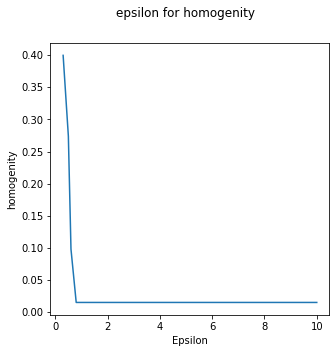

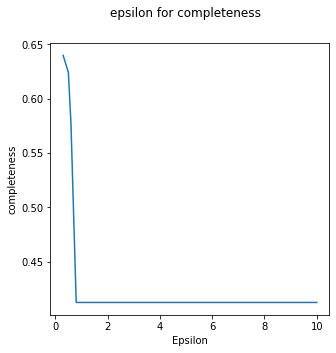

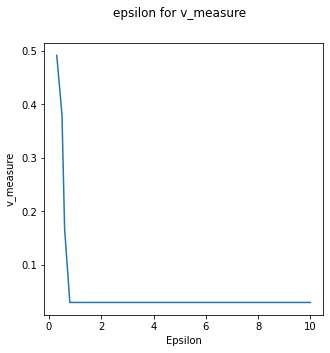

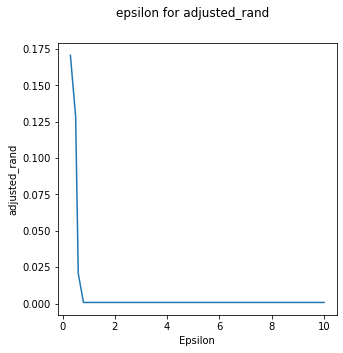

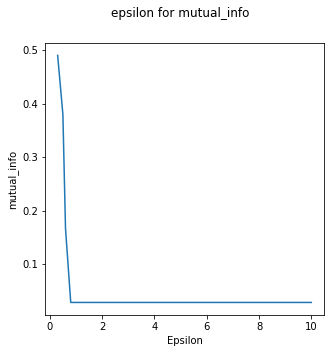

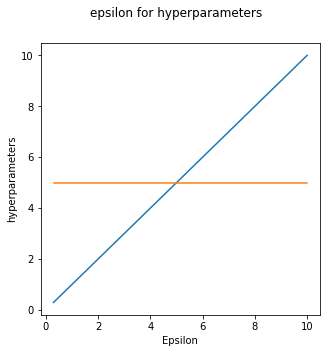

In [113]:
compare_plot_metrics_hdbs(metrics_dict_hdbs)

Homogeneity: 0.445
Completeness: 0.575
V-measure: 0.502
Adjusted Rand-Index: 0.206
Adjusted Mutual Information Score: 0.499
Contingency matrix:


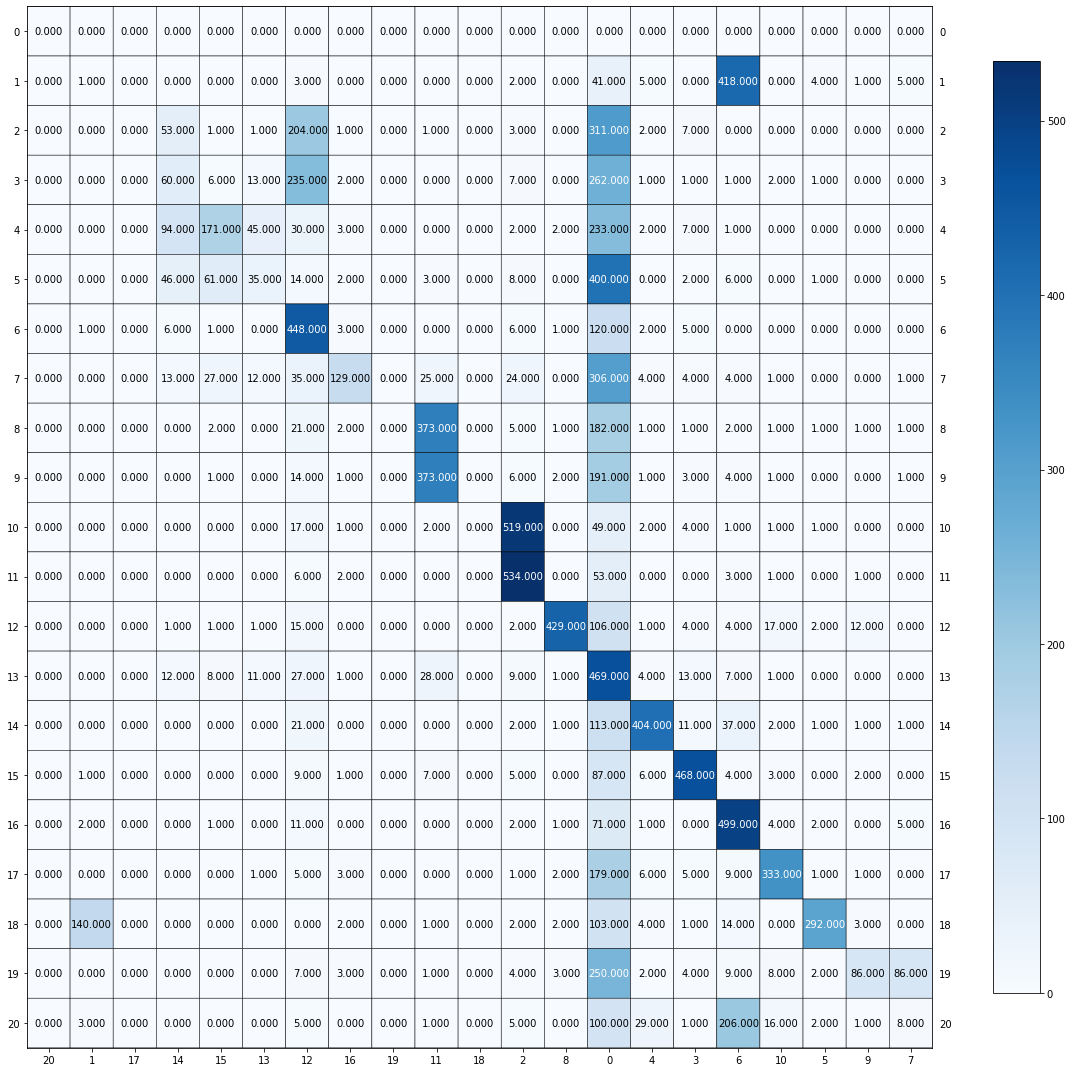

In [114]:
print_metrics(hdbss[best_index_hom_hdbs],labels=y_train_full,train_embeddings=embedding.embedding_)

# QUESTION 17: Based on your experiments, which dimensionality reduction technique and clustering methods worked best together for 20-class text data and why? Follow the table below.

# QUESTION 18: Bonus. If you can find creative ways to further enhance the clustering performance, report your method and the results you obtain